In [1]:
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
import time
import matplotlib.pyplot as plt

In [2]:
# https://www.kaggle.com/competitions/nlp-getting-started

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.8 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!git clone https://github.com/berndheidemann/twitter_disaster_text_classification.git

Cloning into 'twitter_disaster_text_classification'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 39 (delta 16), reused 25 (delta 8), pack-reused 0
Unpacking objects: 100% (39/39), 686.20 KiB | 817.00 KiB/s, done.


In [4]:

#path="./"
path="/kaggle/working/twitter_disaster_text_classification/"
train_csv=path+"train.csv"
test_csv=path+"test.csv"
submission_csv=path+"sample_submission.csv"

df = pd.read_csv(train_csv)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df["keyword"].fillna("None", inplace=True)

In [6]:
df[df.text=="The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'"]

,id,keyword,location,text,target
4284,6087,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,0
4286,6090,hellfire,Riyadh,The Prophet (peace be upon him) said 'Save you...,0
4292,6097,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,1
4304,6111,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,0
4309,6118,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,0
4318,6132,hellfire,NaN,The Prophet (peace be upon him) said 'Save you...,1


# Data cleaning
## remove duplicates with the mean target

In [7]:
# get rows with duplicate text
df_dup = df[df.duplicated(subset=['text'], keep=False)]
# replace target for each unqiue text with the average of the targets
grouped = df_dup.groupby("text")["target"].transform("mean")
df_dup.loc[grouped.index, "target"] = grouped
df_dup
# drop duplicates
#df_dup.drop_duplicates(subset=['text'], keep='first', inplace=True)
#df_dup
# replace entries with text equal to df_dup in df with the new target

# for each text in df_dup replace location with the first not nan location from the rows in df with the same text
df_dup["location"].fillna(df_dup.groupby("text")["location"].transform("first"), inplace=True)

# replace entries with text equal to df_dup in df with the new target
df.loc[df_dup.index, "target"] = df_dup["target"]
df.loc[df_dup.index, "location"] = df_dup["location"]
# remove duplicates (text) in df
df.drop_duplicates(subset=['text'], keep='first', inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [8]:
df[df.text=="The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'"]

,id,keyword,location,text,target
4284,6087,hellfire,Riyadh,The Prophet (peace be upon him) said 'Save you...,0.333333


In [9]:
df["target"] = df["target"].round()
df[df.text=="The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'"]

,id,keyword,location,text,target
4284,6087,hellfire,Riyadh,The Prophet (peace be upon him) said 'Save you...,0.0


In [10]:

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# create iterator from tokenized df
def df_iterator_content(df):
    for _, row in df.iterrows():
        yield tokenizer(row['text'])

vocab = build_vocab_from_iterator(df_iterator_content(df), specials=["<unk>"], min_freq=5)
vocab.set_default_index(vocab["<unk>"])
vocab_size = len(vocab)
print(vocab_size)

3186


In [11]:
def df_iterator_keyword(df):
    for _, row in df.iterrows():
        yield tokenizer(row['keyword'])

vocab_keyword = build_vocab_from_iterator(df_iterator_keyword(df), specials=["<unk>"])
vocab_keyword.set_default_index(vocab_keyword["<unk>"])
vocab_size_keyword = len(vocab_keyword)
print(vocab_size_keyword)

223


In [12]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwitterDisasterDataset(Dataset):
    def __init__(self, df, word_count=500, vocab_size=10000, train=True):
        self.df = df
        self.word_count = word_count
        self.vocab_size = vocab_size
        self.train=train
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        text= self.df.iloc[idx]["text"]
        text = vocab(tokenizer(text))
        if self.train:
            y= self.df.iloc[idx]["target"]
            y = int(y)
        if len(text) > self.word_count:
            text=text[:self.word_count]
        else:
            text.extend([0]*(self.word_count-len(text)))
        text = torch.tensor(text)
        keyword=self.df.iloc[idx]["keyword"]
        keyword = vocab_keyword(tokenizer(keyword))
        keyword = torch.tensor(keyword)

        if self.train:
            return (text.to(device), keyword.to(device)), torch.tensor(y).to(device)
        else:
            return (text.to(device), keyword.to(device))

twitter_dataset = TwitterDisasterDataset(df, word_count=30, vocab_size=vocab_size)
(text, keyword),y=twitter_dataset[23]
print(text)
print(keyword)
print(y)

tensor([137,   5,   0, 119,  14,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0], device='cuda:0')
tensor([1], device='cuda:0')
tensor(0, device='cuda:0')


In [13]:


torch.manual_seed(1)

class MyLSTM(nn.Module):

    def __init__(self, text_embedding_dim, text_hidden_dim, vocab_size, out_size, word_count=50, dropout=0.2, num_layers=2, keyword_embedding_dim=16, hidden_layer_size=64):
        super(MyLSTM, self).__init__()
        self.hidden_dim = text_hidden_dim
        self.text_embedding_dim=text_embedding_dim
        self.text_embeddings = nn.Embedding(vocab_size, text_embedding_dim)
        self.keyword_embeddings = nn.Embedding(vocab_size, keyword_embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(text_embedding_dim, text_hidden_dim, batch_first=True, dropout=dropout, num_layers=num_layers)
        self.dropout=nn.Dropout(p=dropout)

        self.fc_lstm_to_merge = nn.Linear(text_hidden_dim * word_count, keyword_embedding_dim)
        self.bn1 = nn.BatchNorm1d(keyword_embedding_dim*2)
        self.fc_merge_to_hidden = nn.Linear(keyword_embedding_dim*2, hidden_layer_size)
        self.bn2 = nn.BatchNorm1d(hidden_layer_size)
        self.fc_hidden_to_out = nn.Linear(hidden_layer_size, out_size)

    def forward(self, text_b, keyword_b, foo=None):
        #print("xb shape", xb.shape)
        text_embeds = self.text_embeddings(text_b)
        #print("embeds shape", text_embeds.shape)
        lstm_out, _ = self.lstm(text_embeds)
        lstm_out=self.dropout(lstm_out)
        #print("lstm_out shape", lstm_out.shape)
        lstm_out_view = lstm_out.reshape(text_b.shape[0], -1   )
        #print("lstm_out_view shape", lstm_out_view.shape)
        lstm_to_merge = self.fc_lstm_to_merge(lstm_out_view)
        #print("lstm_to_merge shape", lstm_to_merge.shape)
        keyword_embeds = self.keyword_embeddings(keyword_b)
        #print("keyword_embeds shape", keyword_embeds.shape)
        keyword_embeds_view = keyword_embeds.reshape(text_b.shape[0], -1   )
        #print("keyword_embeds_view shape", keyword_embeds_view.shape)
        merged = torch.cat((lstm_to_merge, keyword_embeds_view), dim=1)
        #print("merged shape", merged.shape)
        merged = self.bn1(merged)
        merged = F.relu(merged)
        merged = self.dropout(merged)
        #print("merge shape", merge.shape)
        hidden = self.fc_merge_to_hidden(merged)
        hidden = self.bn2(hidden)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)
        output = self.fc_hidden_to_out(hidden)
        output = F.log_softmax(output, dim=1)
        #print("output shape", output.shape)
        return output

In [14]:

def evaluate(model, dataloader):
    model.eval()
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for idx, (xb, label) in enumerate(dataloader):
            text, keyword = xb
            predicted_label = model(text, keyword)
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predicted_label.argmax(1).cpu().numpy())
    return f1_score(y_true, y_pred)


In [15]:
# Hyperparameter
embed_dim = 128
num_class = 2
hidden_dim = 64
word_count = 50
EPOCHS = 10 # epoch
LR = 0.01  # learning rate
scheduler_patience=4
scheduler_factor=0.2
weight_decay=1e-4
BATCH_SIZE = 64 # batch size for training
dropout=0.7
num_layers=2
hidden_layer_size=64
keyword_embedding_dim=16


# check if model works
model= MyLSTM(embed_dim, hidden_dim, vocab_size, num_class, word_count=word_count, dropout=dropout, num_layers=num_layers, hidden_layer_size=hidden_layer_size, keyword_embedding_dim=keyword_embedding_dim).to(device)
dataset = TwitterDisasterDataset(df, word_count=word_count, vocab_size=vocab_size)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

(text, keyword), yb = next(iter(loader))
print("yb", yb)
print("xb text shape", text.shape)
print("xb keyword shape", keyword.shape)
model(text, keyword)

yb tensor([1, 0, 1, 0, 0], device='cuda:0')
xb text shape torch.Size([5, 50])
xb keyword shape torch.Size([5, 1])


tensor([[-1.2455, -0.3394],
        [-0.5572, -0.8506],
        [-1.6572, -0.2116],
        [-0.4055, -1.0986],
        [-0.7050, -0.6815]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [16]:
# torch.onnx.export(model, (text, keyword), "model.onnx", input_names=["text", "keyword"], output_names=["y_hat"], verbose=True, opset_version=11)

# visualize model with netron.app

In [22]:
# hyperparameter search

param_grid = {
    "embed_dim": [32, 64, 128],
    "hidden_dim": [64, 32, 128],
    "dropout": [0.4, 0.5, 0.7],
    "num_layers": [2, 4],
    "weight_decay": [1e-6],
    "LR": [0.01],
    "BATCH_SIZE": [128, 256],
    "hidden_layer_size": [64],
    "keyword_embedding_dim": [32],
    "word_count": [50]
}

param_grid = ParameterGrid(param_grid)
print(next(iter(param_grid)))
print(len(param_grid))

{'BATCH_SIZE': 128, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 32, 'hidden_dim': 64, 'hidden_layer_size': 64, 'keyword_embedding_dim': 32, 'num_layers': 2, 'weight_decay': 1e-06, 'word_count': 50}
108


In [23]:

def grid_search():

    params_count={}
    for params in param_grid:
        for key, value in params.items():
            param_str=key+":"+str(value)
            if param_str not in params_count:
                params_count[param_str]=1
            else:
                params_count[param_str]+=1
    EPOCHS=10

    # set all random seeds
    torch.manual_seed(1)
    np.random.seed(1)

    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    (gridsearch_portion_idx, test_idx) = next(iter(k_fold.split(df["text"], df["target"])))
    grid_test_df=df.iloc[test_idx]
    gridsearch_df=df.iloc[gridsearch_portion_idx]
    test_dataset=TwitterDisasterDataset(grid_test_df, word_count=word_count, vocab_size=vocab_size)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    k_fold_iter=iter(k_fold.split(gridsearch_df["text"], gridsearch_df["target"]))
    (base_idx, split_portion_idx)=next(k_fold_iter)
    base_df = df.iloc[base_idx]
    split_portion_df = df.iloc[split_portion_idx]
    train_dataset = TwitterDisasterDataset(split_portion_df, word_count=word_count, vocab_size=vocab_size)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    i=0
    best_params_val=0
    best_params=None
    params_results={}
    for params in param_grid:
        i+=1
        model = MyLSTM(params["embed_dim"], params["hidden_dim"], vocab_size, num_class, word_count=word_count, dropout=params["dropout"], num_layers=params["num_layers"]).to(device)
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params["LR"], weight_decay=params["weight_decay"])
        for epoch in range(EPOCHS):
            model.train()
            for idx, (xb, label) in enumerate(train_dataloader):
                text, keyword = xb
                predicted_label = model(text, keyword)
                loss = loss_func(predicted_label, label)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                optimizer.step()
        test_f1 = evaluate(model, test_dataloader)
        print(f"{i} / {len(param_grid)} params {params} Test f1 {test_f1}")
        with open("results.txt", "a") as f:
            f.write(f"{i}: params {params} test f1 {test_f1} \n")
        if test_f1 > best_params_val:
            best_params_val = test_f1
            best_params = params
        for key, value in params.items():
            param_str=key+":"+str(value)
            if param_str not in params_results:
                params_results[param_str]=test_f1
            else:
                params_results[param_str]+=test_f1

    for key, value in params_results.items():
        params_results[key]=params_results[key]/params_count[key]
    return best_params, best_params_val, params_results

best_params, best_params_val, params_results = grid_search()

1 / 108 params {'BATCH_SIZE': 128, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 32, 'hidden_dim': 64, 'hidden_layer_size': 64, 'keyword_embedding_dim': 32, 'num_layers': 2, 'weight_decay': 1e-06, 'word_count': 50} Test f1 0.6579378068739771
2 / 108 params {'BATCH_SIZE': 128, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 32, 'hidden_dim': 64, 'hidden_layer_size': 64, 'keyword_embedding_dim': 32, 'num_layers': 4, 'weight_decay': 1e-06, 'word_count': 50} Test f1 0.4851851851851851
3 / 108 params {'BATCH_SIZE': 128, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 32, 'hidden_dim': 32, 'hidden_layer_size': 64, 'keyword_embedding_dim': 32, 'num_layers': 2, 'weight_decay': 1e-06, 'word_count': 50} Test f1 0.6247818499127399
4 / 108 params {'BATCH_SIZE': 128, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 32, 'hidden_dim': 32, 'hidden_layer_size': 64, 'keyword_embedding_dim': 32, 'num_layers': 4, 'weight_decay': 1e-06, 'word_count': 50} Test f1 0.5190311418685121
5 / 108 params {'BATCH_SIZE': 128, 'LR': 0.01, 'drop

In [26]:
best_params, best_params_val

({'BATCH_SIZE': 256,
  'LR': 0.01,
  'dropout': 0.4,
  'embed_dim': 128,
  'hidden_dim': 32,
  'hidden_layer_size': 64,
  'keyword_embedding_dim': 32,
  'num_layers': 4,
  'weight_decay': 1e-06,
  'word_count': 50},
 0.6798866855524079)

In [27]:
params_results

{'BATCH_SIZE:128': 0.3938719800490844,
 'LR:0.01': 0.3808532296698932,
 'dropout:0.4': 0.5637052363497557,
 'embed_dim:32': 0.33579224904469007,
 'hidden_dim:64': 0.36660617307898236,
 'hidden_layer_size:64': 0.3808532296698932,
 'keyword_embedding_dim:32': 0.3808532296698932,
 'num_layers:2': 0.4452588308348932,
 'weight_decay:1e-06': 0.3808532296698932,
 'word_count:50': 0.3808532296698932,
 'num_layers:4': 0.31644762850489344,
 'hidden_dim:32': 0.38742970766887463,
 'hidden_dim:128': 0.38852380826182303,
 'embed_dim:64': 0.37799438101792554,
 'embed_dim:128': 0.4287730589470644,
 'dropout:0.5': 0.5027639631105051,
 'dropout:0.7': 0.07609048954941927,
 'BATCH_SIZE:256': 0.36783447929070223}

In [38]:
hyperparams = {'BATCH_SIZE': 256,
  'LR': 0.01,
  'dropout': 0.4,
  'embed_dim': 128,
  'hidden_dim': 32,
  'hidden_layer_size': 64,
  'keyword_embedding_dim': 32,
  'num_layers': 4,
  'weight_decay': 1e-06,
  'word_count': 50}


BATCH_SIZE=hyperparams["BATCH_SIZE"]
LR = hyperparams["LR"]
embed_dim = hyperparams["embed_dim"]
hidden_dim = hyperparams["hidden_dim"]
num_layers = hyperparams["num_layers"]
weight_decay = hyperparams["weight_decay"]
word_count = hyperparams["word_count"]
hidden_layer_size=hyperparams["hidden_layer_size"]
keyword_embedding_dim=hyperparams["keyword_embedding_dim"]
EPOCHS = 7
scheduler_patience=4
scheduler_factor=0.2

In [39]:

# create train and valid dataset
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

# import torch DataLoader
from torch.utils.data import DataLoader

model = MyLSTM(embed_dim, hidden_dim, vocab_size, num_class, word_count=word_count, dropout=dropout, keyword_embedding_dim=keyword_embedding_dim, hidden_layer_size=hidden_layer_size ).to(device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)   # every 10 epochs, LR is multiplied by 0.7
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=scheduler_factor, patience=scheduler_patience)


-----------------------------------------------------------
| end of epoch   1 | time:  9.62s | train f1    0.477 | valid f1    0.478 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   2 | time:  9.54s | train f1    0.133 | valid f1    0.113 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   3 | time:  9.47s | train f1    0.732 | valid f1    0.670 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   4 | time:  9.90s | train f1    0.840 | valid f1    0.751 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   5 | time:  9.25s | train f1    0.870 | valid f1    0.737 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   6 | time:  9.49s | train f1    0.911 | valid f1    0.750 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   7 | time:  9.93s | train f1    0.93

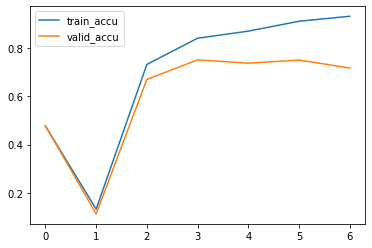

In [40]:
total_accu = None
train_accus=[]
valid_accus=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    model.train()
    total_acc, total_count = 0, 0

    for idx, (xb, label) in enumerate(train_dataloader):
        text, keyword = xb
        optimizer.zero_grad()
        predicted_label = model(text, keyword)
        loss = loss_func(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    accu_train = evaluate(model, train_dataloader)
    accu_valid = evaluate(model, valid_dataloader)
    train_accus.append(accu_train)
    valid_accus.append(accu_valid)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train f1 {:8.3f} | valid f1 {:8.3f} | lr: {:1.5f}'.format(
        epoch,
        time.time() - epoch_start_time,
        accu_train,
        accu_valid,
        optimizer.param_groups[0]['lr']))

    scheduler.step(accu_valid) # learning rate scheduler after each epoch

plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [31]:
df_test = pd.read_csv(test_csv)
df_test["keyword"].fillna("None", inplace=True)
df_test.head()

,id,keyword,location,text
0,0,None,NaN,Just happened a terrible car crash
1,2,None,NaN,"Heard about #earthquake is different cities, s..."
2,3,None,NaN,"there is a forest fire at spot pond, geese are..."
3,9,None,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,None,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [32]:
test_dataset = TwitterDisasterDataset(df_test, word_count=word_count, vocab_size=vocab_size, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

predictions=[]
model.eval()
with torch.no_grad():
    for idx, xb in enumerate(test_dataloader):
        text, keyword = xb
        predicted_label = model(text, keyword)
        predictions.append(predicted_label.argmax(1).cpu().numpy())
        

predictions=np.concatenate(predictions)
print(predictions.shape)

(3263,)


In [33]:
df_submission = pd.read_csv(submission_csv)
df_submission["target"] = predictions
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [34]:
df_submission.to_csv("submission.csv", index=False)